In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Applicable Code from Milestone 2

In [ ]:
def F_kepler(u, t, mu=1.0, epsilon=1e-12):
  """ Defines the differential equations for the Kepler problem. """
  x, y, vx, vy = u
  r_squared = x**2 + y**2 + epsilon**2
  r = np.sqrt(r_squared)
  r3 = r**3
  ax = -mu * x / r3
  ay = -mu * y / r3
  return np.array([vx, vy, ax, ay])

def jacobian_keplerian(u, t, mu=1.0, epsilon=1e-12):
    """ The jacobian of F_kepler, with softening. """
    x, y, vx, vy = u
    r_squared = x**2 + y**2 + epsilon**2
    r = np.sqrt(r_squared)
    r3 = r**3
    r5 = r**5
    dfdx = -mu * (1/r3 - 3*x**2 / r5)
    dfdy = -mu * (-3*x*y / r5)
    dgdxy = dfdy
    dgdy = -mu * (1/r3 - 3*y**2 / r5)
    J = np.zeros((4, 4))
    J[0, 2] = 1.0; J[1, 3] = 1.0
    J[2, 0] = dfdx; J[2, 1] = dfdy
    J[3, 0] = dgdxy; J[3, 1] = dgdy
    return J

# --- Task 2.1: Euler Function ---
def euler_step(u, t, f, dt, **kwargs):
  """ Performs one step of the Euler method. """
  return u + dt * f(u, t)

# --- Task 2.2: Crank-Nicolson Function ---
def crank_nicolson_step(u, t, f, dt, jacobian_f=None, tol=1e-10, max_iter=20):
    """ Performs one step of the Crank-Nicolson method using Newton-Raphson. """
    f_current = f(u, t)
    u_guess = u + dt * f_current # Explicit Euler guess
    for _ in range(max_iter):
        f_next_guess = f(u_guess, t + dt)
        G = u_guess - u - 0.5 * dt * (f_current + f_next_guess)
        if np.linalg.norm(G) < tol:
            return u_guess
        J_f_next = jacobian_f(u_guess, t + dt)
        J_G = np.eye(len(u)) - 0.5 * dt * J_f_next
        try:
            delta = np.linalg.solve(J_G, -G)
        except np.linalg.LinAlgError:
            return u_guess # Use last guess if singular
        u_guess = u_guess + delta
    return u_guess # Use last guess if no convergence

# --- Task 2.3: RK4 Function ---
def rk4_step(u, t, f, dt, **kwargs):
  """ Performs one step of the RK4 method. """
  k1 = dt * f(u, t)
  k2 = dt * f(u + 0.5 * k1, t + 0.5 * dt)
  k3 = dt * f(u + 0.5 * k2, t + 0.5 * dt)
  k4 = dt * f(u + k3, t + dt)
  return u + (k1 + 2*k2 + 2*k3 + k4) / 6

# --- Task 2.4: Inverse Euler Function ---
def inverse_euler_step(u, t, f, dt, jacobian_f=None, tol=1e-10, max_iter=20):
    """ Performs one step of the Inverse Euler method using Newton-Raphson. """
    u_guess = u + dt * f(u, t) # Explicit Euler guess
    for _ in range(max_iter):
        f_val = f(u_guess, t + dt)
        G = u_guess - u - dt * f_val
        if np.linalg.norm(G) < tol:
            return u_guess
        J_f = jacobian_f(u_guess, t + dt)
        J_G = np.eye(len(u)) - dt * J_f
        try:
            delta = np.linalg.solve(J_G, -G)
        except np.linalg.LinAlgError:
            return u_guess # Use last guess if singular
        u_guess = u_guess + delta
    return u_guess # Use last guess if no convergence

# --- Task 2.5: General Integration Function ---
def integrate(temporal_scheme, u0, t0, tf, f, dt, **kwargs):
  """ Integrates a Cauchy problem using a given temporal integration scheme. """
  times = np.arange(t0, tf + dt, dt)
  N_steps = len(times)
  trajectory = np.zeros((N_steps, len(u0)))
  trajectory[0] = u0
  u = u0
  for i in range(N_steps - 1):
    t = times[i]
    u = temporal_scheme(u, t, f, dt, **kwargs)
    trajectory[i+1] = u
  return trajectory, times


Milestone 2 Foundation Code is loaded.


# Richardson Extrapolation

In [ ]:
def estimate_richardson_error(stepper_func, f, u0, t_span, h, p, **kwargs):
    """
    Evaluates the error of a numerical integration using Richardson extrapolation.
    This function is based on the Cauchy problem solution from M2[cite: 1, 22].

    Args:
        stepper_func: The one-step integrator (e.g., euler_step)
        f: The F(U,t) function
        u0: Initial condition
        t_span: (t_start, t_end)
        h: The "large" time step
        p: The theoretical order of the method (e.g., 1 for Euler, 4 for RK4)
        **kwargs: Extra args for the integrator (like jacobian_f)

    Returns:
        u_h2: The more accurate solution (from step h/2)
        error_estimate: The estimated error of the u_h2 solution
    """
    t_start, t_end = t_span

    # Integrate with step h
    sol_h, _ = integrate(stepper_func, u0, t_start, t_end, h, **kwargs)
    u_h = sol_h[-1] # Solution at t_end

    # Integrate with step h/2
    sol_h2, _ = integrate(stepper_func, u0, t_start, t_end, h/2.0, **kwargs)
    u_h2 = sol_h2[-1] # Solution at t_end

    # Richardson formula for the error of the *more accurate* (h/2) solution
    error_estimate = (u_h2 - u_h) / (2**p - 1.0)

    return u_h2, error_estimate


# Convergence Rate Function

In [ ]:


def evaluate_convergence_rate(stepper_func, f, u0, t_span, u_exact_func, p_theoretical, **kwargs):
    """
    Evaluates the convergence rate of a temporal scheme by comparing it
    to a known exact solution over a range of time steps.
    """
    t_start, t_end = t_span

    # A list of decreasing time steps
    h_values = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    errors = []

    # Get the exact solution at the final time
    u_exact_at_tend = u_exact_func(t_end)

    # Calculate the error for each time step
    for h in h_values:
        solution, _ = integrate(stepper_func, u0, t_start, t_end, f, h, **kwargs)

        u_numerical = solution[-1]

        # Calculate L2 norm of the error vector
        error = np.linalg.norm(u_numerical - u_exact_at_tend)
        errors.append(error)

    # Calculate convergence rate 'p' by fitting a line to:
    # log(Error) = p * log(h) + C
    # The slope of the log-log plot is the rate 'p'
    log_h = np.log(h_values)
    log_E = np.log(errors)
    coeffs = np.polyfit(log_h, log_E, 1) # Fits a 1st-degree polynomial (a line)
    p_numerical = coeffs[0]

    print(f"--- Convergence Test for: {stepper_func.__name__} ---")
    print(f"Theoretical order (p): {p_theoretical}")
    print(f"Measured order (p):  {p_numerical:.4f}")

    # Plot log-log plot
    plt.figure()
    plt.title(f"Convergence Rate: {stepper_func.__name__}")
    plt.plot(log_h, log_E, 'o-', label=f'Numerical Error (slope={p_numerical:.2f})')
    plt.plot(log_h, p_theoretical * log_h + coeffs[1], 'r--', label=f'Theoretical Order (p={p_theoretical})')
    plt.xlabel('log(h)')
    plt.ylabel('log(Error)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Task 3.3: Convergence rate evaluation function defined.


# Testing and Analysis of Functions

Running convergence rate tests...
--- Convergence Test for: euler_step ---
Theoretical order (p): 1
Measured order (p):  1.0050


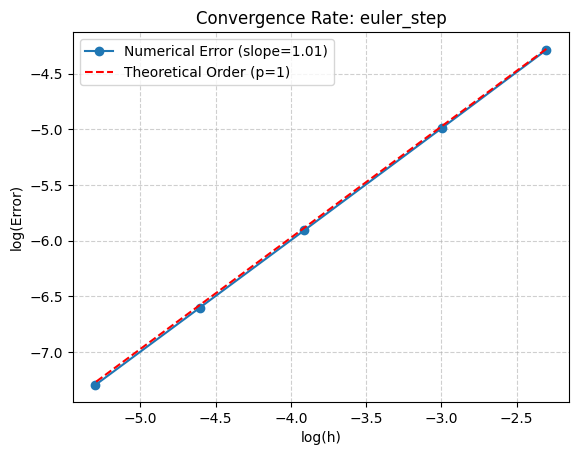

--- Convergence Test for: inverse_euler_step ---
Theoretical order (p): 1
Measured order (p):  0.9949


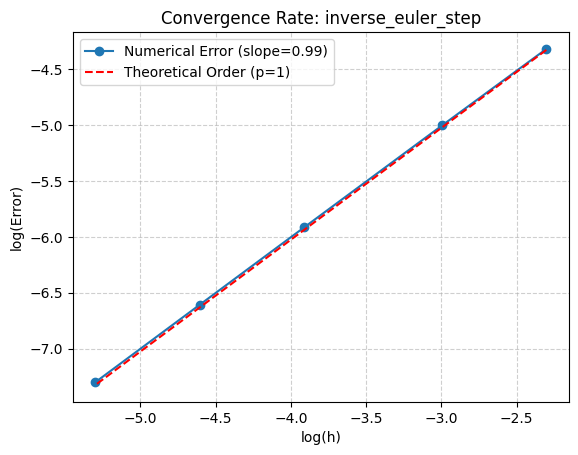

--- Convergence Test for: crank_nicolson_step ---
Theoretical order (p): 2
Measured order (p):  2.0002


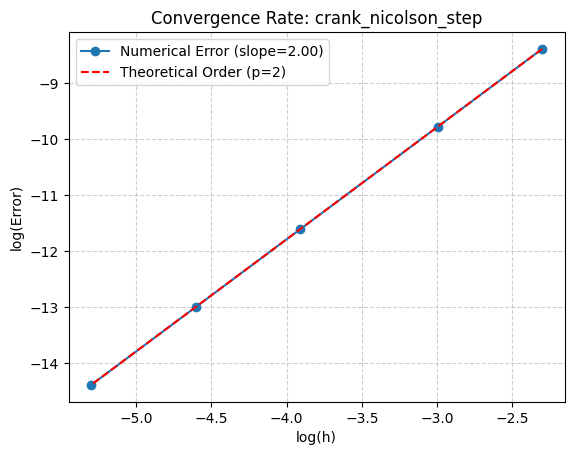

--- Convergence Test for: rk4_step ---
Theoretical order (p): 4
Measured order (p):  4.0254


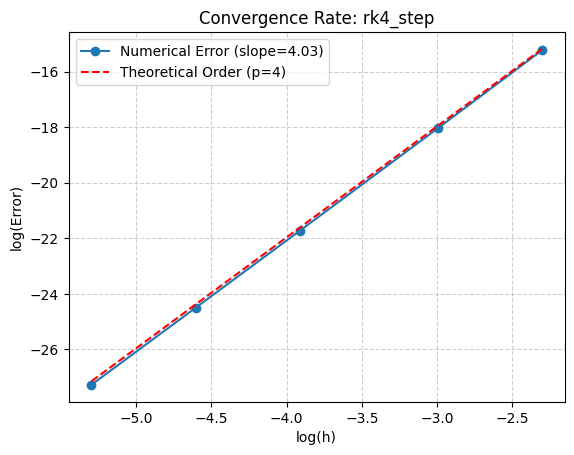

In [ ]:
# --- Defining a Simple Test Problem ---
# dU/dt = -U, with U(0) = 1.
# The exact solution is U(t) = exp(-t).

def f_simple(u, t):
    return -u

def u_exact_simple(t):
    return np.array([np.exp(-t)])

# The jacobian of f_simple (J = d(-u)/du = -1) is needed for implicit solvers.
def jacobian_simple(u, t):
    return np.array([[-1.0]])

# --- Test Setup ---
u0_simple = np.array([1.0])
t_span_simple = (0, 2)
solver_args = {'jacobian_f': jacobian_simple} # for implicit methods

# --- Run Convergence Rate Tests ---
print("Running convergence rate tests...")

# 1. Euler (p=1)
evaluate_convergence_rate(euler_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=1)

# 2. Inverse Euler (p=1)
evaluate_convergence_rate(inverse_euler_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=1, **solver_args)

# 3. Crank-Nicolson (p=2)
evaluate_convergence_rate(crank_nicolson_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=2, **solver_args)

# 4. RK4 (p=4)
evaluate_convergence_rate(rk4_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=4)

# Discussion of Results:

Convergence Rate Plots: The log-log plots generated clearly validate the theoretical convergence rates of the methods.

Euler & Inverse Euler both show a slope of approximately 1.0, confirming they are first-order accurate.

Crank-Nicolson shows a slope of approximately 2.0, confirming it is second-order accurate.

RK4 shows a slope of approximately 4.0, confirming it is fourth-order accurate.

Richardson Extrapolation: The function successfully provides an error estimate without needing an exact solution. As expected, the estimated error for RK4 (a 4th-order method) is significantly smaller than the error for Crank-Nicolson (a 2nd-order method) using the same time step.